In [ ]:
!pip install PyWavelets

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import time
import cv2
import pywt
from scipy import signal

Matrix-based DFT

FFT (Numpy) Time: 0.001719 seconds
Matrix-based DFT Time: 0.011078 seconds


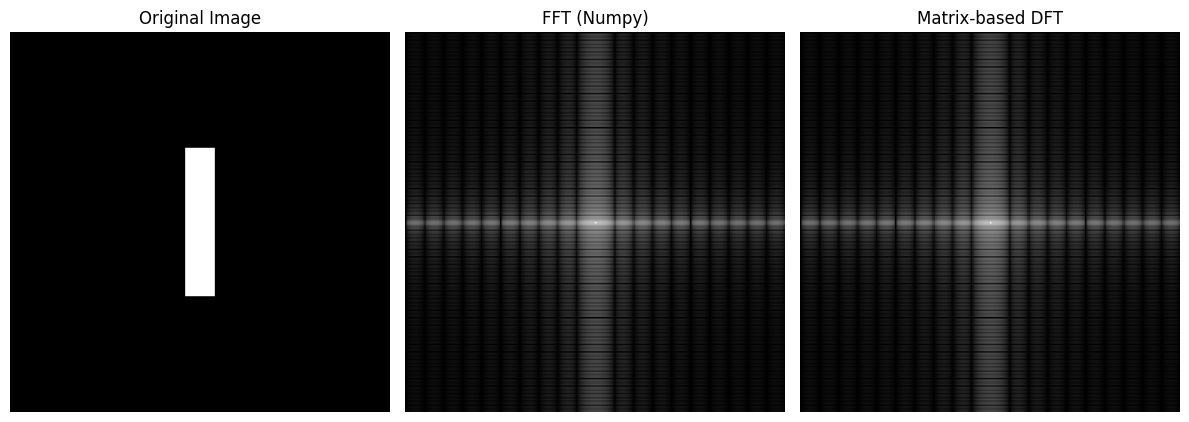

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time

def dft_matrix(N):
    """
    Generate the DFT matrix for a given size N.
    
    Input:
    - N: The size of the DFT matrix (int).
    
    Output:
    - W: N x N DFT matrix (complex-valued).
    """
    n = np.arange(N)
    k = n.reshape((N, 1))
    W = np.exp(-2j * np.pi * k * n / N)
    return W


def matrix_dft2(image):
    """
    Compute the 2D DFT of an image using matrix multiplication.
    
    Input:
    - image: 2D numpy array representing the grayscale image.
    
    Output:
    - 2D DFT of the image using matrix-based DFT.
    """
    N, M = image.shape
    W_N = dft_matrix(N)  # DFT matrix for rows
    W_M = dft_matrix(M)  # DFT matrix for columns
    
    # Apply DFT to the rows and then to the columns
    return np.dot(W_N, np.dot(image, W_M))


# Load image and convert to grayscale if necessary
image = plt.imread('rectangular_pulse.png')  
if image.ndim == 3:  
    image = np.mean(image, axis=2)


fft_result = np.fft.fft2(image)
matrix_dft_result = matrix_dft2(image)

# Shift the FFT and DFT results for better visualization
fft_shifted = np.fft.fftshift(fft_result)
matrix_dft_shifted = np.fft.fftshift(matrix_dft_result)

# Compute magnitude spectra for visualization
fft_magnitude = np.log(np.abs(fft_shifted) + 1)
matrix_dft_magnitude = np.log(np.abs(matrix_dft_shifted) + 1)

# Plot the original image, FFT result, and matrix-based DFT result
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(fft_magnitude, cmap='gray')
plt.title('FFT (Numpy)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(matrix_dft_magnitude, cmap='gray')
plt.title('Matrix-based DFT')
plt.axis('off')

plt.tight_layout()
plt.show()


Basis Images

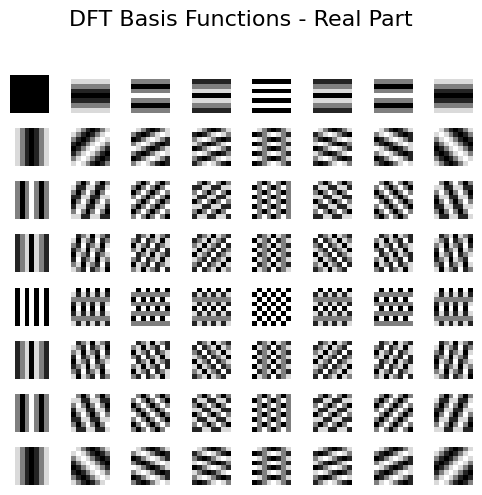

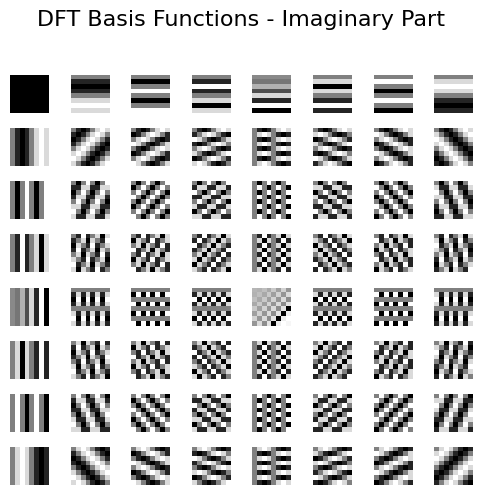

In [34]:
def dft_basis_function(N, u, v):
    n1, n2 = np.meshgrid(np.arange(N), np.arange(N))
    basis = np.exp(-2j * np.pi * (u * n1 / N + v * n2 / N))
    return basis

N = 8  


plt.figure(figsize=(5, 5))
for u in range(N):
    for v in range(N):
        basis = dft_basis_function(N, u, v)
        plt.subplot(N, N, u * N + v + 1)
        plt.imshow(np.real(basis), cmap='gray', extent=[0, N-1, 0, N-1])
        plt.axis('off')

plt.suptitle('DFT Basis Functions - Real Part', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

plt.figure(figsize=(5, 5))
for u in range(N):
    for v in range(N):
        basis = dft_basis_function(N, u, v)
        plt.subplot(N, N, u * N + v + 1)
        plt.imshow(np.imag(basis), cmap='gray', extent=[0, N-1, 0, N-1])
        plt.axis('off')

plt.suptitle('DFT Basis Functions - Imaginary Part', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


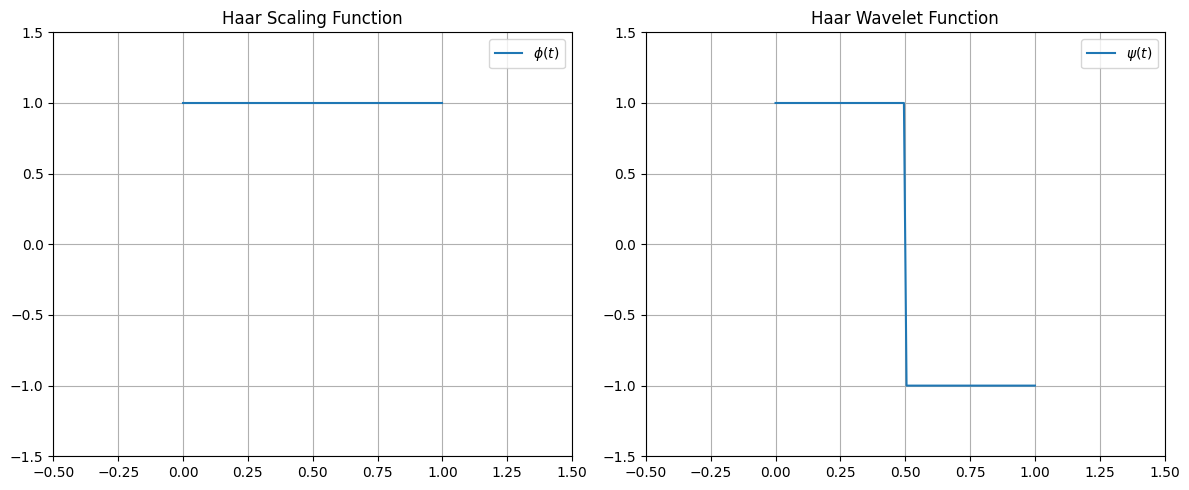

In [35]:
def haar_scaling_function(length):
    return np.ones(length)

def haar_wavelet_function(length):
    half = length // 2
    return np.concatenate((np.ones(half), -np.ones(half)))


t = np.linspace(0, 1, 100)
length = 100 


scaling_values = haar_scaling_function(length)
wavelet_values = haar_wavelet_function(length)


scaling_values_full = np.zeros_like(t)
wavelet_values_full = np.zeros_like(t)

scaling_values_full[(t >= 0) & (t <= 1)] = scaling_values
wavelet_values_full[(t >= 0) & (t <= 1)] = wavelet_values

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(t, scaling_values_full, label=r'$\phi(t)$')
plt.title('Haar Scaling Function')
plt.grid(True)
plt.ylim(-1.5, 1.5)
plt.xlim(-0.5, 1.5)
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(t, wavelet_values_full, label=r'$\psi(t)$')
plt.title('Haar Wavelet Function')
plt.grid(True)
plt.ylim(-1.5, 1.5)
plt.xlim(-0.5, 1.5)
plt.legend()

plt.tight_layout()
plt.show()


wavelet transform

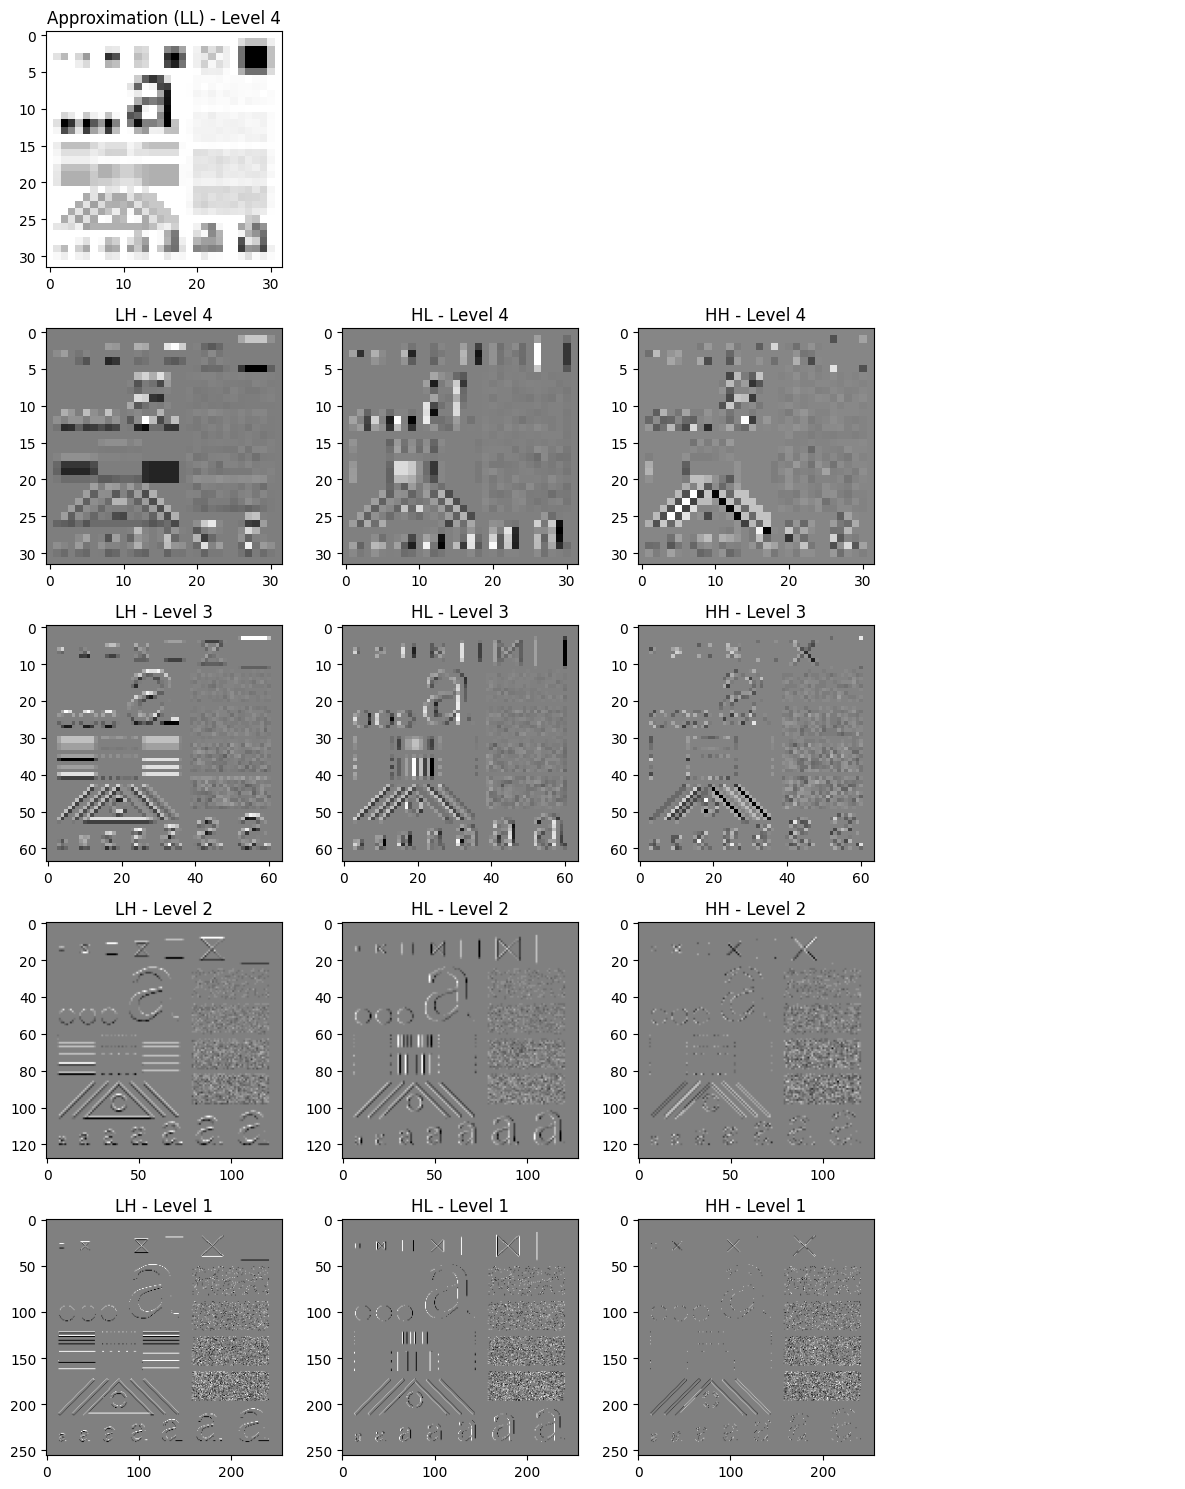

In [36]:
def display_wavelet_transform(image, wavelet='haar', level=4):
    # Convert image to grayscale if it's a color image
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Perform 2D wavelet decomposition
    coeffs = pywt.wavedec2(image, wavelet, level=level)
    
    # Extract approximation coefficients (LL) and detail coefficients (LH, HL, HH)
    LL = coeffs[0]
    details = coeffs[1:]
    
    # Plot the approximation and details
    fig, axes = plt.subplots(level + 1, 4, figsize=(12, 3 * (level + 1)))
    
    # Show the approximation (LL) at the highest level
    axes[0, 0].imshow(LL, cmap='gray')
    axes[0, 0].set_title(f'Approximation (LL) - Level {level}')
    axes[0, 1].axis('off')
    axes[0, 2].axis('off')
    axes[0, 3].axis('off')

    # Show details (LH, HL, HH) for each level
    for i, (LH, HL, HH) in enumerate(details):
        axes[i + 1, 0].imshow(LH, cmap='gray')
        axes[i + 1, 0].set_title(f'LH - Level {level - i}')
        
        axes[i + 1, 1].imshow(HL, cmap='gray')
        axes[i + 1, 1].set_title(f'HL - Level {level - i}')
        
        axes[i + 1, 2].imshow(HH, cmap='gray')
        axes[i + 1, 2].set_title(f'HH - Level {level - i}')
        
        # Hide any unused axes
        axes[i + 1, 3].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage
image = cv2.imread('testpattern512-binary.tif')  # Replace with your image path
display_wavelet_transform(image, wavelet='haar', level=4)


Wavelet-based progressive image reconstruction

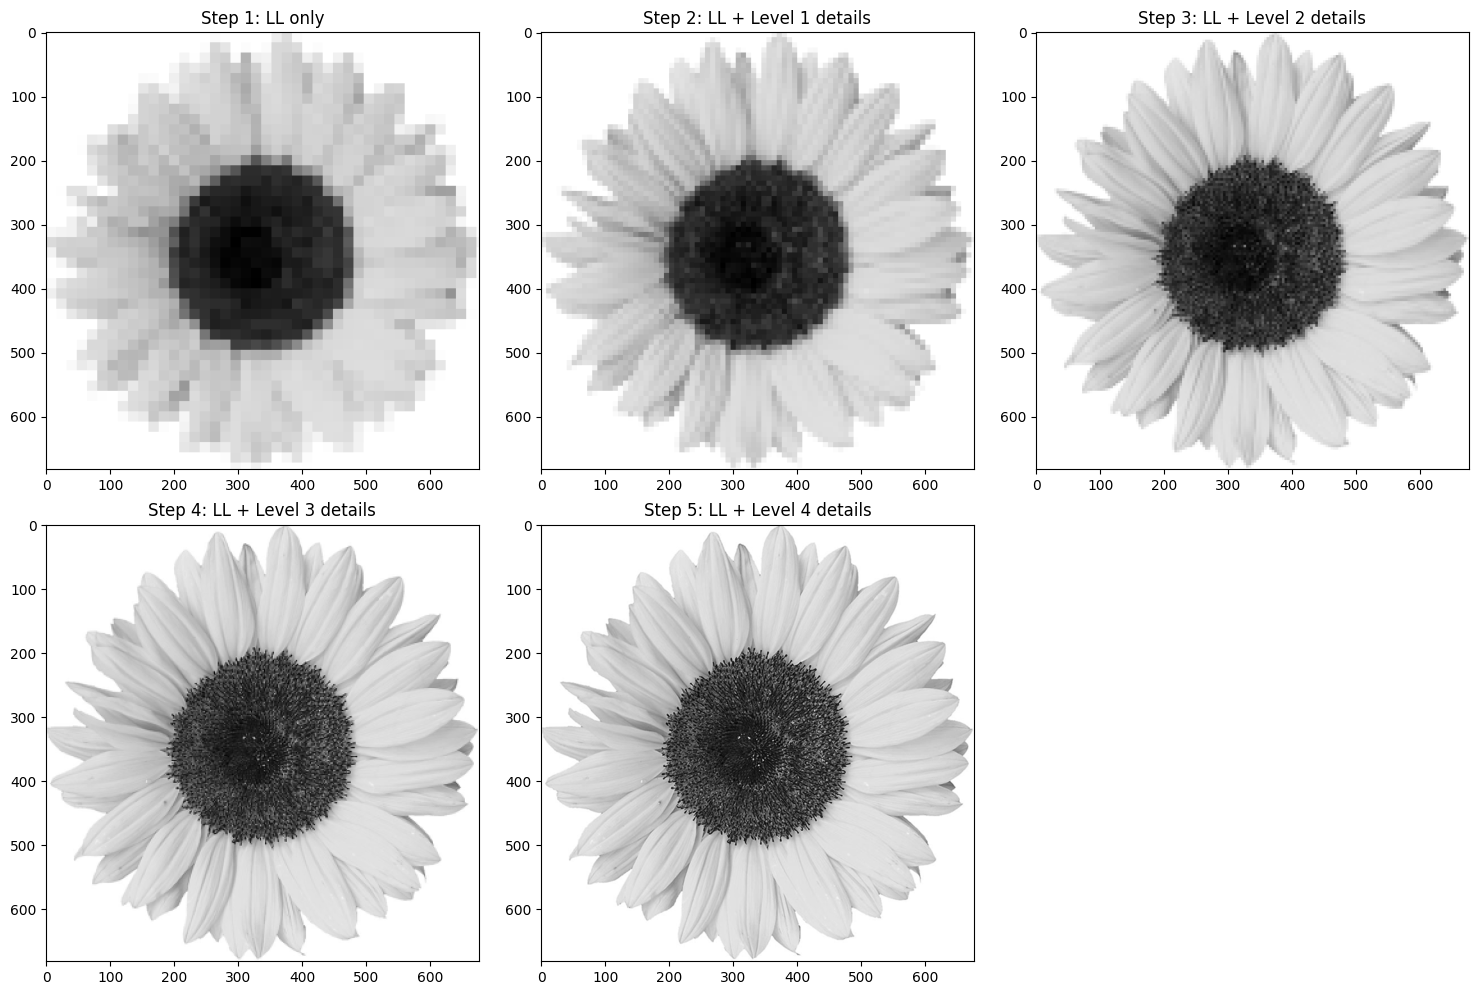

In [37]:
def progressive_reconstruction(image, wavelet='haar', level=4):
    """
    Perform progressive reconstruction from wavelet coefficients.
    
    Parameters:
    - image: Input grayscale image.
    - wavelet: Type of wavelet to use (e.g., 'haar').
    - level: Number of decomposition levels.
    
    Returns:
    - None (Displays the progressive reconstruction steps)
    """
    # Step 1: Convert image to grayscale if necessary
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Step 2: Perform 2D wavelet decomposition
    coeffs = pywt.wavedec2(image, wavelet, level=level)
    
    # Step 3: Start with only the approximation coefficients (LL)
    # Initialize coeffs_progressive with LL, and set the rest of the coefficients (LH, HL, HH) to zero
    coeffs_progressive = [coeffs[0]]  # Initialize with LL (lowest frequency component)
    for i in range(1, level + 1):
        # Hint: Initialize LH, HL, and HH components to zeros for each level
        # Student Task: Complete this part by assigning zeros for the high-frequency components (LH, HL, HH)
        coeffs_progressive.append((np.zeros_like(coeffs[i][0]),  
                                   np.zeros_like(coeffs[i][1]),  
                                   np.zeros_like(coeffs[i][2]))) 

    plt.figure(figsize=(15, 10))

    # Step 4: Progressive reconstruction
    # Student Task: Use pywt.waverec2 to perform the inverse wavelet transform using coeffs_progressive
    # Hint: pywt.waverec2(coeffs, wavelet) reconstructs an image from the wavelet coefficients
    # Example: reconstruction = pywt.waverec2(coeffs_progressive, wavelet)
    
    # Step 5: Reconstruction starting with LL only (lowest frequency component)
    # Student Task: Complete the line to perform inverse wavelet transform
    reconstruction = pywt.waverec2(coeffs_progressive, wavelet)
    reconstruction = np.clip(reconstruction, 0, 255)
    
    plt.subplot(2, 3, 1)
    plt.imshow(reconstruction, cmap='gray')
    plt.title('Step 1: LL only')

    # Step 6: Gradually add details (LH, HL, HH) for each level
    for i in range(1, level + 1):
        # Add the details (LH, HL, HH) of level i
        coeffs_progressive[i] = coeffs[i]

        # Student Task: Perform inverse wavelet transform again with updated coefficients
        # Hint: Use the same function pywt.waverec2 as above
        reconstruction = pywt.waverec2(coeffs_progressive, wavelet)
        reconstruction = np.clip(reconstruction, 0, 255)

        plt.subplot(2, 3, i + 1)
        plt.imshow(reconstruction, cmap='gray')
        plt.title(f'Step {i + 1}: LL + Level {i} details')

    plt.tight_layout()
    plt.show()

# Example usage
image = cv2.imread('/home/ma859/438labs/sunflower.tif', cv2.IMREAD_GRAYSCALE)  # Replace with your image path
progressive_reconstruction(image, wavelet='haar', level=4)


Wavelet-based image smoothing

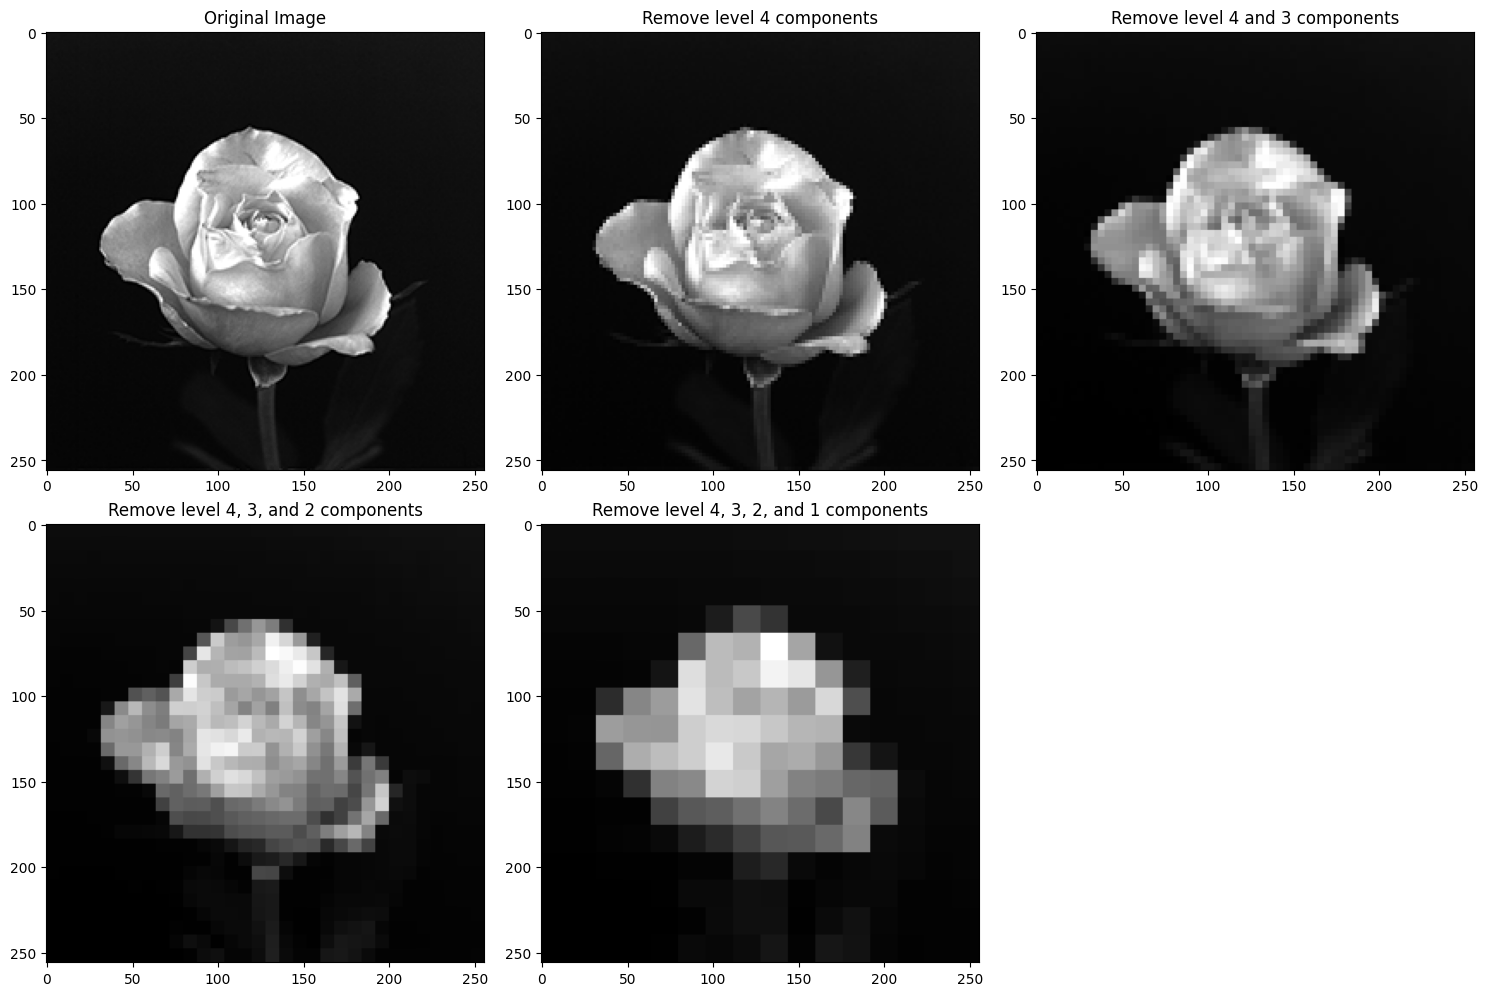

In [38]:
def wavelet_blurring(image, wavelet='haar', level=4, remove_levels=[]):
    """
    Apply wavelet-based image blurring by removing high-frequency components at specified levels.
    
    Parameters:
    - image: Input grayscale image.
    - wavelet: Type of wavelet to use (e.g., 'haar').
    - level: Number of decomposition levels.
    - remove_levels: List of levels at which high-frequency components should be removed.
    
    Returns:
    - blurred_image: Blurred image after inverse wavelet reconstruction.
    """
    # Convert image to grayscale if it's a color image
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Perform 2D wavelet decomposition
    coeffs = pywt.wavedec2(image, wavelet, level=level)
    
    # Remove high-frequency components at the specified levels
    coeffs_blurred = coeffs.copy()
    for i in range(1, level + 1):
        if i in remove_levels:
            # Set LH, HL, HH components to zero for the specified levels
            coeffs_blurred[i] = (np.zeros_like(coeffs_blurred[i][0]),
                                 np.zeros_like(coeffs_blurred[i][1]),
                                 np.zeros_like(coeffs_blurred[i][2]))

    # Reconstruct the image using the modified coefficients
    blurred_image = pywt.waverec2(coeffs_blurred, wavelet)
    
    # Clip values to valid range [0, 255] for images
    blurred_image = np.clip(blurred_image, 0, 255)
    
    return blurred_image

def display_progressive_blurring(image, wavelet='haar', level=4):
    # Display images with progressively less high-frequency detail
    plt.figure(figsize=(15, 10))

    # Original image
    plt.subplot(2, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    
    # Start from removing the highest level (4) and go down to the lowest (1)
    blurred_4 = wavelet_blurring(image, wavelet=wavelet, level=level, remove_levels=[4])
    plt.subplot(2, 3, 2)
    plt.imshow(blurred_4, cmap='gray')
    plt.title('Remove level 4 components')

    blurred_3 = wavelet_blurring(image, wavelet=wavelet, level=level, remove_levels=[4, 3])
    plt.subplot(2, 3, 3)
    plt.imshow(blurred_3, cmap='gray')
    plt.title('Remove level 4 and 3 components')

    blurred_2 = wavelet_blurring(image, wavelet=wavelet, level=level, remove_levels=[4, 3, 2])
    plt.subplot(2, 3, 4)
    plt.imshow(blurred_2, cmap='gray')
    plt.title('Remove level 4, 3, and 2 components')

    blurred_1 = wavelet_blurring(image, wavelet=wavelet, level=level, remove_levels=[4, 3, 2, 1])
    plt.subplot(2, 3, 5)
    plt.imshow(blurred_1, cmap='gray')
    plt.title('Remove level 4, 3, 2, and 1 components')
    
    plt.tight_layout()
    plt.show()

# Example usage
image = cv2.imread('rose256.tif', cv2.IMREAD_GRAYSCALE)  # Replace with your image path
display_progressive_blurring(image, wavelet='haar', level=4)


Wavelet-based edge detection

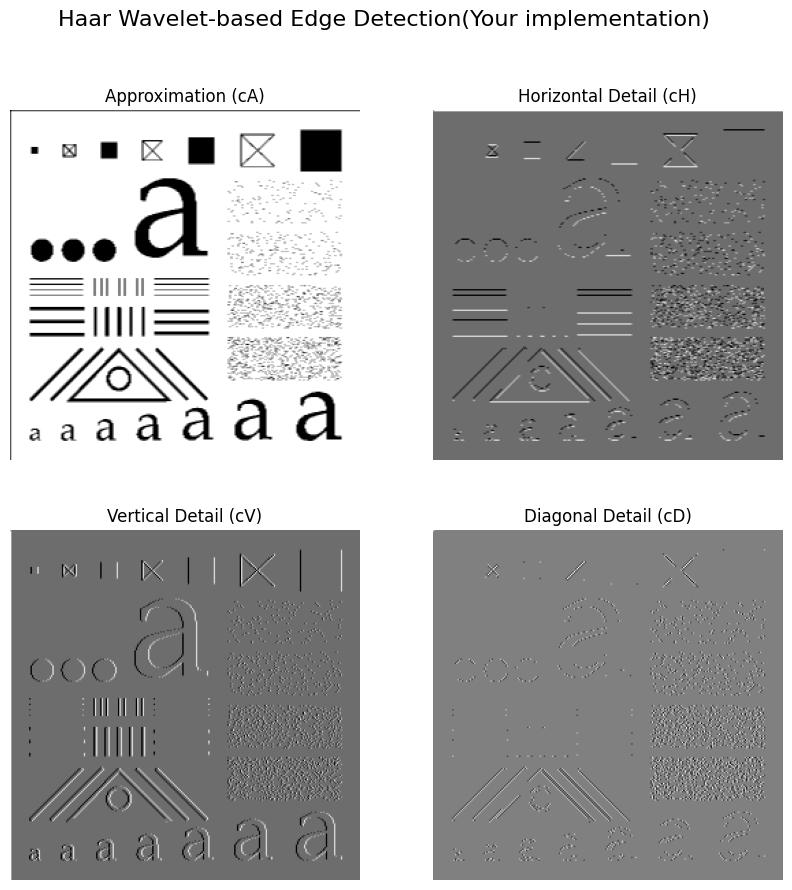

In [39]:
import numpy as np
import matplotlib.pyplot as plt


# Haar wavelet low-pass and high-pass filters
low_pass_filter = np.array([1/np.sqrt(2), 1/np.sqrt(2)])
high_pass_filter = np.array([1/np.sqrt(2), -1/np.sqrt(2)])

def convolve_and_downsample(image, filter_):
    """Convolve image with filter and downsample"""
    # Convolution in horizontal direction
    result = signal.convolve2d(image, filter_[:, np.newaxis], mode='same')
    # Downsampling
    result = result[:, ::2]  # Take every second column
    return result

def dwt2_custom(image):
    """Manual 2D Discrete Wavelet Transform (DWT)"""
    # Horizontal convolution with low-pass and high-pass filters
    low_filtered = convolve_and_downsample(image, low_pass_filter)
    high_filtered = convolve_and_downsample(image, high_pass_filter)

    # Vertical convolution with low-pass and high-pass filters
    LL = convolve_and_downsample(low_filtered.T, low_pass_filter).T  # Low-Low
    LH = convolve_and_downsample(low_filtered.T, high_pass_filter).T  # Low-High
    HL = convolve_and_downsample(high_filtered.T, low_pass_filter).T  # High-Low
    HH = convolve_and_downsample(high_filtered.T, high_pass_filter).T  # High-High

    return LL, (LH, HL, HH)

# Test image
image = plt.imread('testpattern512-binary.tif')
if image.ndim == 3: 
    image = np.mean(image, axis=2)

# Perform custom 2D DWT
LL, (LH, HL, HH) = dwt2_custom(image)

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.imshow(LL, cmap='gray')
plt.title('Approximation (cA)')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(HL, cmap='gray')
plt.title('Horizontal Detail (cH)')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(LH, cmap='gray')
plt.title('Vertical Detail (cV)')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(HH, cmap='gray')
plt.title('Diagonal Detail (cD)')
plt.axis('off')

plt.suptitle('Haar Wavelet-based Edge Detection(Your implementation)', fontsize=16)
plt.show()


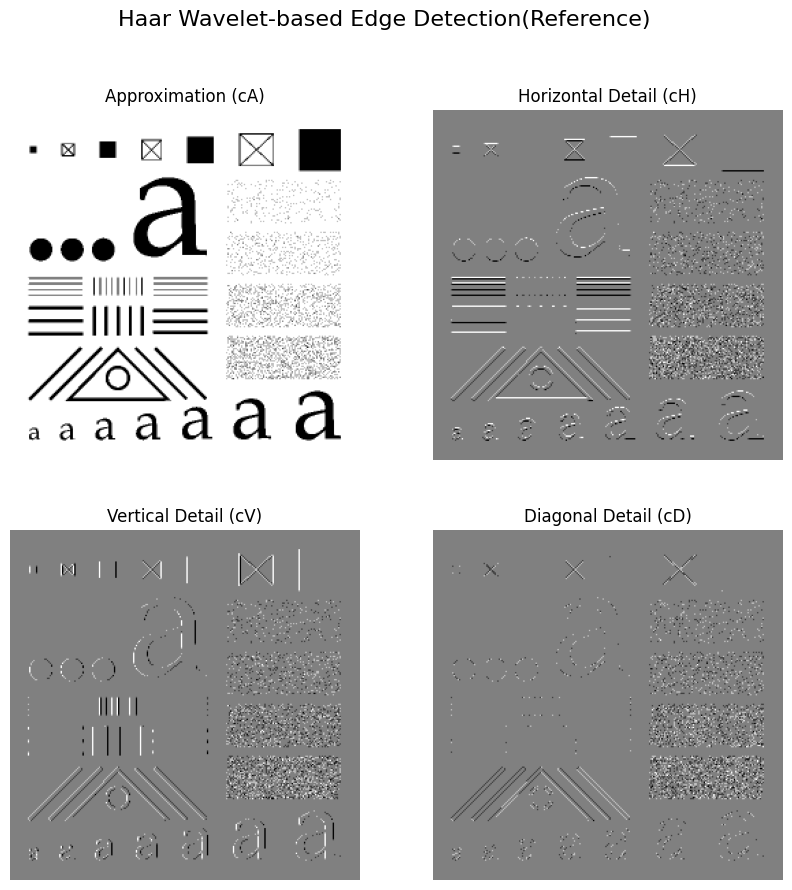

In [40]:
coeffs2 = pywt.dwt2(image, 'haar')
cA, (cH, cV, cD) = coeffs2


plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.imshow(cA, cmap='gray')
plt.title('Approximation (cA)')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(cH, cmap='gray')
plt.title('Horizontal Detail (cH)')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(cV, cmap='gray')
plt.title('Vertical Detail (cV)')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(cD, cmap='gray')
plt.title('Diagonal Detail (cD)')
plt.axis('off')

plt.suptitle('Haar Wavelet-based Edge Detection(Reference)', fontsize=16)
plt.show()
